# Performing Matching for Causal Inference on "Lalonde" Dataset


Data sourced from

https://github.com/robjellis/lalonde/blob/master/lalonde_data.csv


Based on the notebook demonstrating the causalinference package, at:

https://rugg2.github.io/Lalonde%20dataset%20-%20Causal%20Inference.html

## Importing Packages

In [1]:
##Import packages

#Data Processing
import pandas as pd
import numpy as np

#Finding the data on our system
import pathlib

#Matching library
from causalinference import CausalModel

#Scikit-Learn linear regression
from sklearn import linear_model

#Scaling
from sklearn.preprocessing import StandardScaler

#Splitting data into training and test
from sklearn.model_selection import train_test_split

#Metrics to evaluate


#Plotting library
import matplotlib.pyplot as plt

## Import Data

### Understanding the Dataset

The Lalonde dataset is a classic example used for causal inference.
# I should write something about the original paper here, and then review other things that I've written


In this dataset, we see individuals and try to find the impact that the treatment (an educational training) has on their income in 1978. All the information we have on each individual is as follows:

- ID - a unique identifier for the individual (we'll drop this because it doesn't tell us anything)
- treat - 1 or 0 - if the individual recieved the treatment
- age - integer - the age of the individual
- educ - int - the number of years of education that the individual has recieved
- black - 1 or 0 - if the individual is black
- hispan - 1 or 0 - if the individual is hispanic
- married - 1 or 0 - if the individual is married
- nodegree - 1 or 0 - if the individual does not have a degree (0 = degree, 1 = no degree)
- re74 - real number - the income of the individual in 1974 (prior to the treatment)
- re75 - real number - the income of the individual in 1975 (prior to the treatment)
- re78 - real number - the outcome variable - the income of the individual in 1978 (after treatment of those who recieved it)

Unfortunately, re74 and re75 have a lot of missing values (0 income), which weakens our analysis. However, missing values can be indicative of something about the individual, so we can still actually match on these! We will probably end up matching those people with missing values to other people that have missing values.

In [2]:
#Import data

#Find the file from a local directiory
p = str(pathlib.Path().resolve()).replace("\\Notebooks\\Matching and Causal Inference", "")
p += ("\\Data\\Raw\\lalonde_data.csv")
p = pathlib.Path(p).resolve()

#Read into a pandas dataframe
df = pd.read_csv(p)

#Preview the dataset
df.head()

,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


(array([421.,  97.,  53.,  19.,  14.,   5.,   1.,   3.,   0.,   1.]),
 array([    0.   ,  2514.224,  5028.448,  7542.672, 10056.896, 12571.12 ,
        15085.344, 17599.568, 20113.792, 22628.016, 25142.24 ]),
 <BarContainer object of 10 artists>)

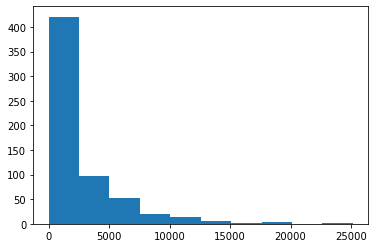

In [3]:
#Have a look at the distribution of the re75 column - loads of 0s here
plt.hist(df["re75"])

In [4]:
#Dropping na rows and columns as discussed above

#Drop na rows
df = df.dropna()

#Drop ID column
df = df.drop(["ID"], axis=1)

#Show the new DataFrame
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,1,33,8,1,0,0,1,0.0,0.0,289.7899


## Most Simple Treatment Effect

The absolutely most simple way that we can get a treatment effect is by comparing the means of the data. Currently, the data is imbalanced, with 429 untreated individuals, and 185 treated invidiuals. This method is not valid for finding causality (ie, we can't say that the treatment here "causes" any difference in income), as it does not take into account factors determining which people sign up for the treatment.

In [5]:
#Find the mean income of individuals who took part in the training
mean_treat = np.mean(df[df["treat"] == 1]["re78"])

print(mean_treat)

6349.143530270271


In [6]:
#Find the mean income of those who did not take part in the training
mean_control = np.mean(df[df["treat"] == 0]["re78"])

print(mean_control)

6984.169742307692


In [7]:
print(f"Estimated treatment effect: ${mean_treat - mean_control}")

Estimated treatment effect: $-635.0262120374209


We see here that the mean income for those taking the treatment is lower! Is the treatment worse than nothing?

## Data Exploration

From a bit of exploration, we can see that the distribution of individuals in each group is really different. This tells us, like we might expect, that the types of people that take part in the treatment programme are different to those who don't. We can see straight away, for example, that the ages of those in the treatment group are generally younger than those in the control group.

In [8]:
#How many observations are there?
df.shape

(614, 10)

In [9]:
#How many of these received the treatment?
len(df[df["treat"] == 1])

185

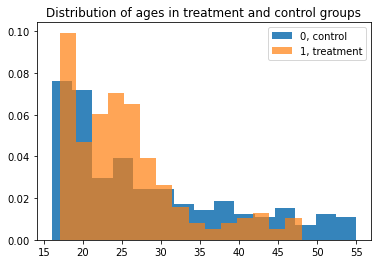

In [10]:
#Plot the treated and control group's age distribution
plt.hist(df[df["treat"] == 0]["age"], label="0, control", bins=15, density=True, alpha=0.9)
plt.hist(df[df["treat"] == 1]["age"], label="1, treatment", bins=15, density=True, alpha=0.7)

plt.title("Distribution of ages in treatment and control groups")
plt.legend()

We don't really need to understand the difference in distributions past here in this case, as we have shown that they're different. We'll fix this in matching later - so we can approximate a causal relationship.

However, we can look at a couple of our other covariates, just to drive home the point of the difference, and the effect of self-selection on the groups

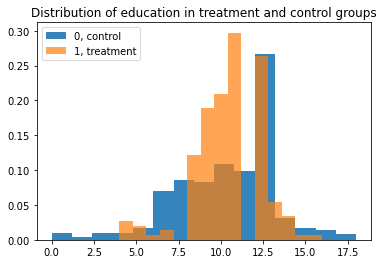

In [11]:
#Plot the treated and control group's education distribution
plt.hist(df[df["treat"] == 0]["educ"], label="0, control", bins=15, density=True, alpha=0.9)
plt.hist(df[df["treat"] == 1]["educ"], label="1, treatment", bins=15, density=True, alpha=0.7)

plt.title("Distribution of education in treatment and control groups")
plt.legend()

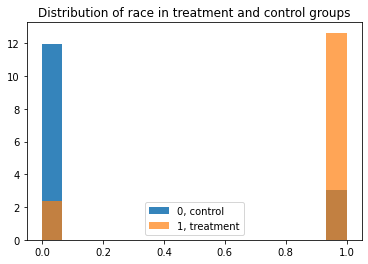

In [12]:
#Plot the treated and control group's racial distribution
plt.hist(df[df["treat"] == 0]["black"], label="0, control", bins=15, density=True, alpha=0.9)
plt.hist(df[df["treat"] == 1]["black"], label="1, treatment", bins=15, density=True, alpha=0.7)

plt.title("Distribution of race in treatment and control groups")
plt.legend()

This one is particularly telling - the proportion of black people in the treatment group is way lower than the control group.

## Slightly More Complex - A Linear Regression

One of the more valid methods that we can use to try to find the effect of the treatment is a linear regression. This takes into account differences in the covariates (or confounding variables), to find a difference associated with taking part in the treatment. We can implement this in Scikit-Learn, or the causalinference library that we're using for the other analysis in this notebook.

If you're unfamiliar with the methods of linear regressions, check out the article on these methods, to see the maths behind how they work. Otherwise, in simple terms, we are fitting a best-fit line to our data across many dimensions (independent variables). We can then find the slope of this line across each one of the dimensions, to find an *associated* increase with this variable. Keep in mind that this is a correlation!

In [13]:
#Firstly we check for autocorrelation, something that can affect the regression

#Display a matrix of correlation coefficients (r)
corr = df.corr()
corr

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,1.000000,-0.102893,0.019308,0.600907,-0.117983,-0.301334,0.105857,-0.249779,-0.130197,-0.039033
age,-0.102893,1.000000,-0.125622,-0.110730,-0.053400,0.376059,-0.069218,0.333254,0.140022,0.106249
educ,0.019308,-0.125622,1.000000,-0.010528,-0.174153,-0.095051,-0.701452,0.136583,0.018301,0.161538
black,0.600907,-0.110730,-0.010528,1.000000,-0.294973,-0.317118,0.109278,-0.257334,-0.140374,-0.120977
hispan,-0.117983,-0.053400,-0.174153,-0.294973,1.000000,0.021549,0.100869,-0.007091,0.061589,0.015325
married,-0.301334,0.376059,-0.095051,-0.317118,0.021549,1.000000,-0.032349,0.425739,0.353824,0.162358
nodegree,0.105857,-0.069218,-0.701452,0.109278,0.100869,-0.032349,1.000000,-0.208751,-0.070412,-0.142418
re74,-0.249779,0.333254,0.136583,-0.257334,-0.007091,0.425739,-0.208751,1.000000,0.552002,0.343416
re75,-0.130197,0.140022,0.018301,-0.140374,0.061589,0.353824,-0.070412,0.552002,1.000000,0.257659
re78,-0.039033,0.106249,0.161538,-0.120977,0.015325,0.162358,-0.142418,0.343416,0.257659,1.000000


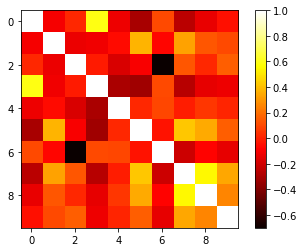

In [14]:
plt.imshow(corr, cmap="hot")
plt.colorbar()

The autocorrelation here isn't ideal, but no values meet our threshold for being dropped.

In [15]:
#Split dependent variable from other covariates

X = df.drop("re78", axis=1)
y = df["re78"]

In [16]:
#Train a linear regression

reg = linear_model.LinearRegression()

reg.fit(X, y)

LinearRegression()

In [17]:
#Find the coefficients for each variable
for i, name in enumerate(X.columns):
    print(f"{name}: {reg.coef_[i]}")

print(f"Intercept: {reg.intercept_}")

treat: 1548.2438019996032
age: 12.977633712836582
educ: 403.9412308557339
black: -1240.6440820318776
hispan: 498.8968649589451
married: 406.6208454241389
nodegree: 259.8173680421699
re74: 0.29637744288605106
re75: 0.23152587573791328
Intercept: 66.51451970467042


In [18]:
#Show that using causalinference we get the same associated treatment effect:

#Define the model
# Y is the dependent variable, D is the treatment indicator, and X is the covariates / confounding variables
# We will continue using this model through the rest of the notebook - lines 6-9 are important to run
# even if you don't perform the linear regression!
causal = CausalModel(
    Y=df['re78'].values, 
    D=df['treat'].values, 
    X=df[["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]].values)

#Train the model with a linear regression
# adj=1 tells the model to perform a linear regression
# adj=0 would perform our "most simple estimate", 
# and adj=2 would perform a degree 2 polynomial regresssion
causal.est_via_ols(adj=1)

#Print out the results
print(causal.estimates)


Treatment Effect Estimates: OLS

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1548.244    734.521      2.108      0.035    108.584   2987.904



C:\Users\Cameron\Anaconda3\lib\site-packages\causalinference\estimators\ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


Here, we find a treatment effect of \\$1548.24 - suggesting that the treatment has quite a positive effect on people's income. However, this is only a correlation, and as always, we can't say the treatment causes this - there is still the self-selection of people enrolling in the treatment. An interesting result from the causalinference package is the 95\% confidence interval - from this we can say that if we repeated the whole experiment, 95\% of the time we expect our estimated treatment effect to lie between \\$108.54 and \\$2987.90. In other words, we're over 97.5\% sure that the treatment is associated with a positive effect. Unfortunately though, we cannot say for sure that the true value is in our 95\% confidence interval.

As such, we can say from this that participation in the treatment is associated with an increase of $1548 in income in 1978. However, this disagrees with our most simple method. In general, we would trust the linear regression here, as it is a more valid method for comparison, and the p-value is sufficiently low to reject a null hypothesis of no impact.

Can we do better still? Yes - next comes matching

## Matching to Infer Causality

In matching, we find matches for each treated individual that are similar across the other variables that we have values for. To achieve this, we need to have overlap between our treated and untreated group, so we can maximise the balance by matching. To check this balance, we can look at the summary statistics, to find the normalised difference between the groups for each variable. This is done below, with our already defined causal model.

The normalised difference metric (Nor-diff) that we look at is defined by Imbens & Rubin (2015), and is a measure of the overlap between two groups. We will use a cutoff of absolute value greater than 0.5 to determine when two variables are unbalanced. Initially, there are several unbalanced variables (X2, X4 and X6), that we can begin to work on.

In [19]:
print(causal.summary_stats)


Summary Statistics

                       Controls (N_c=429)         Treated (N_t=185)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     6984.170     7294.162     6349.144     7867.402     -635.026

                       Controls (N_c=429)         Treated (N_t=185)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       28.030       10.787       25.816        7.155       -0.242
             X1       10.235        2.855       10.346        2.011        0.045
             X2        0.203        0.403        0.843        0.365        1.668
             X3        0.142        0.350        0.059        0.237       -0.277
             X4        0.513        0.500        0.189        0.393       -0.719
      

The first thing that we can do to improve the balance of the groups is to remove outliers. In this case, we will estimate the propensity score (probability that an individual would be selected for the treatment) for each person. Next, we remove those who are extremely unlikely to be selected for the treatment, or who are extremely likely to be selected for the treatment.

In [20]:
#Estimate propensity scores for each person in the dataset
causal.est_propensity_s()

In [21]:
#Remove the outliers here - propensity score less than 0.1 or more than 0.9 by default
causal.trim_s()

In [22]:
#View the balance again
print(causal.summary_stats)


Summary Statistics

                       Controls (N_c=157)         Treated (N_t=140)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     5476.633     6020.122     6351.987     6397.833      875.353

                       Controls (N_c=157)         Treated (N_t=140)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       23.777        7.418       24.986        7.510        0.162
             X1       10.210        2.405       10.329        2.177        0.052
             X2        0.471        0.501        0.836        0.372        0.826
             X3        0.248        0.433        0.071        0.258       -0.496
             X4        0.261        0.441        0.221        0.417       -0.093
      

This is slightly better - now only X2 ("black") has a value above the cutoff. We can now attempt matching to find our average treatment effect.

Firstly, we match each treated observation to a single untreated observation. This gives us an average treatment effect (ATE) of \\$383.51, though the p-value shows this is not a significant difference, and the confidence interval shows just how different we might expect our treatment effect to be if we repeated the experiment.

The other estimators (ATC and ATT) represent the average treatment effect for those in the control group, and treatment group, respectively. From here, we suggest that the treatment might have been more effective for those in the control group, had they decided to take it up. However, again, these results are not significant, and the p-values are high enough for it to be likely that there is no difference between the groups, and the variation is down to chance alone.

In [23]:
#Match to a single control observation
causal.est_via_matching(bias_adj=True, matches=1)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    383.508   1206.472      0.318      0.751  -1981.177   2748.193
           ATC    594.156   1504.175      0.395      0.693  -2354.027   3542.338
           ATT    147.281   1368.636      0.108      0.914  -2535.245   2829.807



C:\Users\Cameron\Anaconda3\lib\site-packages\causalinference\estimators\matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


Next, we can allow for multiple matches. This means that each treated observation is matched to several untreated observations, and the ATE is estimated again.

With 2 matches per treated individual, we find an average treatment effect of \\$696.52. However, we still can't say that this is significant, due to our p-value of 0.464. With 4 matches, we find an estimated average treatment effect of \\$1027.09, which is more similar to our regressional value, though still not significant.

In [24]:
#Match to a single control observation
causal.est_via_matching(bias_adj=True, matches=2)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    696.523    951.769      0.732      0.464  -1168.945   2561.990
           ATC    318.389   1110.114      0.287      0.774  -1857.435   2494.213
           ATT   1120.572   1040.227      1.077      0.281   -918.273   3159.417



In [25]:
#Match to a single control observation
causal.est_via_matching(bias_adj=True, matches=4)
print(causal.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1027.087    883.785      1.162      0.245   -705.131   2759.305
           ATC    754.217   1006.164      0.750      0.453  -1217.865   2726.298
           ATT   1333.092    937.670      1.422      0.155   -504.741   3170.925



## Conclusions

From what we see in matching, we can get a better idea of the effect of the treatment, including a p-value to know if the treatment has a significant effect on the population. In this case, because of the high p-values, we can't rule out that the difference in groups is only due to chance, similarly to the predictions made by Lalonde (1986) intitially.

However, when working with data from separate groups, we can infer causation much more strongly this way - if we had gotten significant results, we would be much happier in inferring that the cause of the increase was self-selection in the treatment (note this is not directly participation in the treatment, as all we know is about the type of person likely to select themselves for the treatment, as they may work in other ways to improve their income differently to those in the control group). With non-human participants, ie plants or other organisms, we could control more factors and know more about the impact of the treatment itself.

## References

Imbens, G. W., & Rubin, D. B. (2015). Causal inference in statistics, social, and biomedical sciences. Cambridge University Press.

LaLonde, R. J. (1986). Evaluating the econometric evaluations of training programs with experimental data. The American economic review, 604-620. https://www.jstor.org/stable/1806062?seq=1#metadata_info_tab_contents